# Cluster Models:

Clustering models are unsupervised model that don't need labels. these models explore the hidden patterns and structures of data.<br>
___
**The goal of project:** 

- Find the patterns of countries in country dataset based on the components of comfotable life for citizens.
- specify where *GCC* countries ranke compared to others.

## import the primary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

## import country dataset:

In [2]:
df = pd.read_csv('Country-data.csv')

df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


## **explore the data:**

- find missing values.
- split the data based on its type (numeric - categorical).
- find relationships between features based on graphs.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [4]:
x = df.drop(columns=['country'])
countries = df['country']

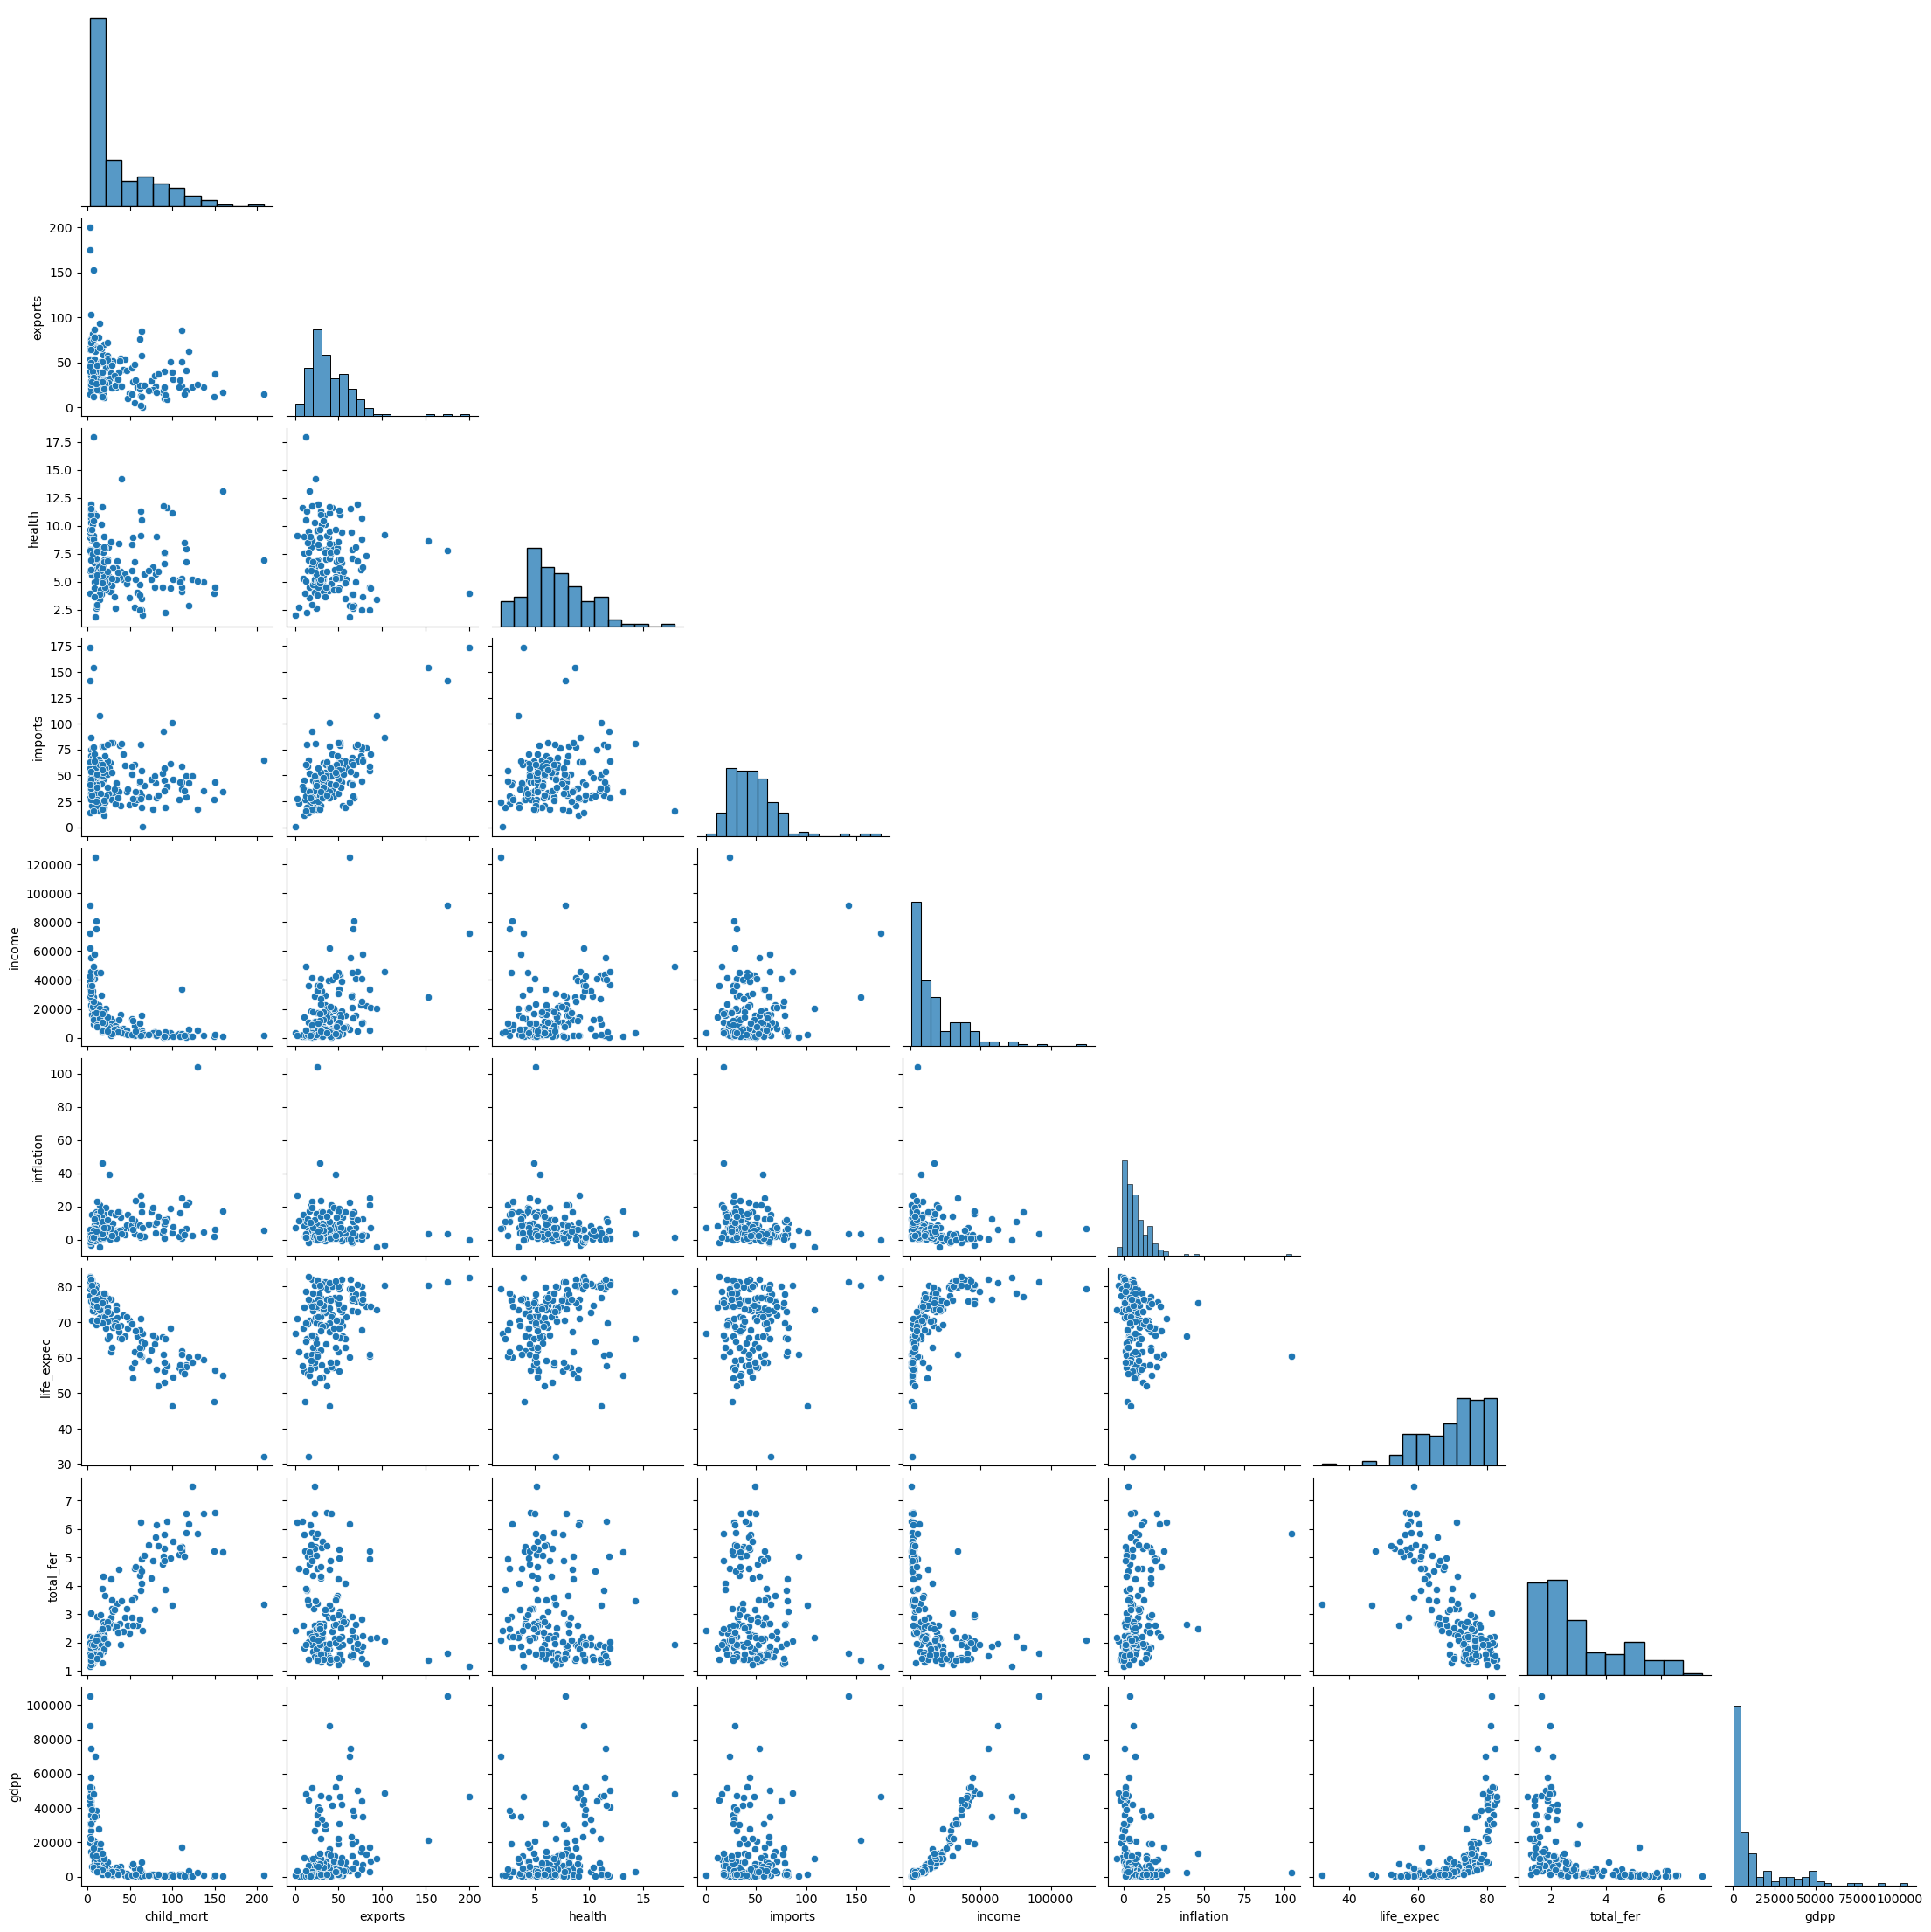

In [5]:
# draw a pairplot:
sn.pairplot(data=x ,corner=True)
plt.show()

From the graphs, we see some linear relations between features, so it can use PCA for dimentional reduction.

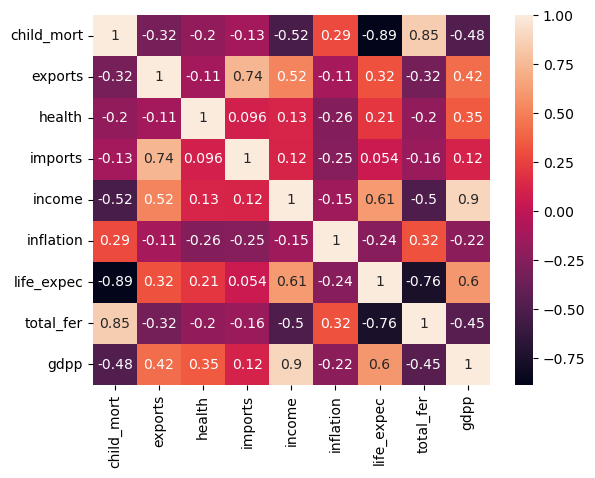

In [6]:
# draw a heatmap:
x_corr = x.corr()

sn.heatmap(data=x_corr, annot=True)
plt.show()

From heatmap, we can drop *'income'* because it has a high correlation between it and *'gdpp'* (measure of a country's economic output).<br>
Also can drop *'total_fer'* (The average number of children a woman is expected to have over her lifetime) for the same reason.

In [7]:
x = x.drop(columns=['income', 'total_fer'])
x.shape[1]

7

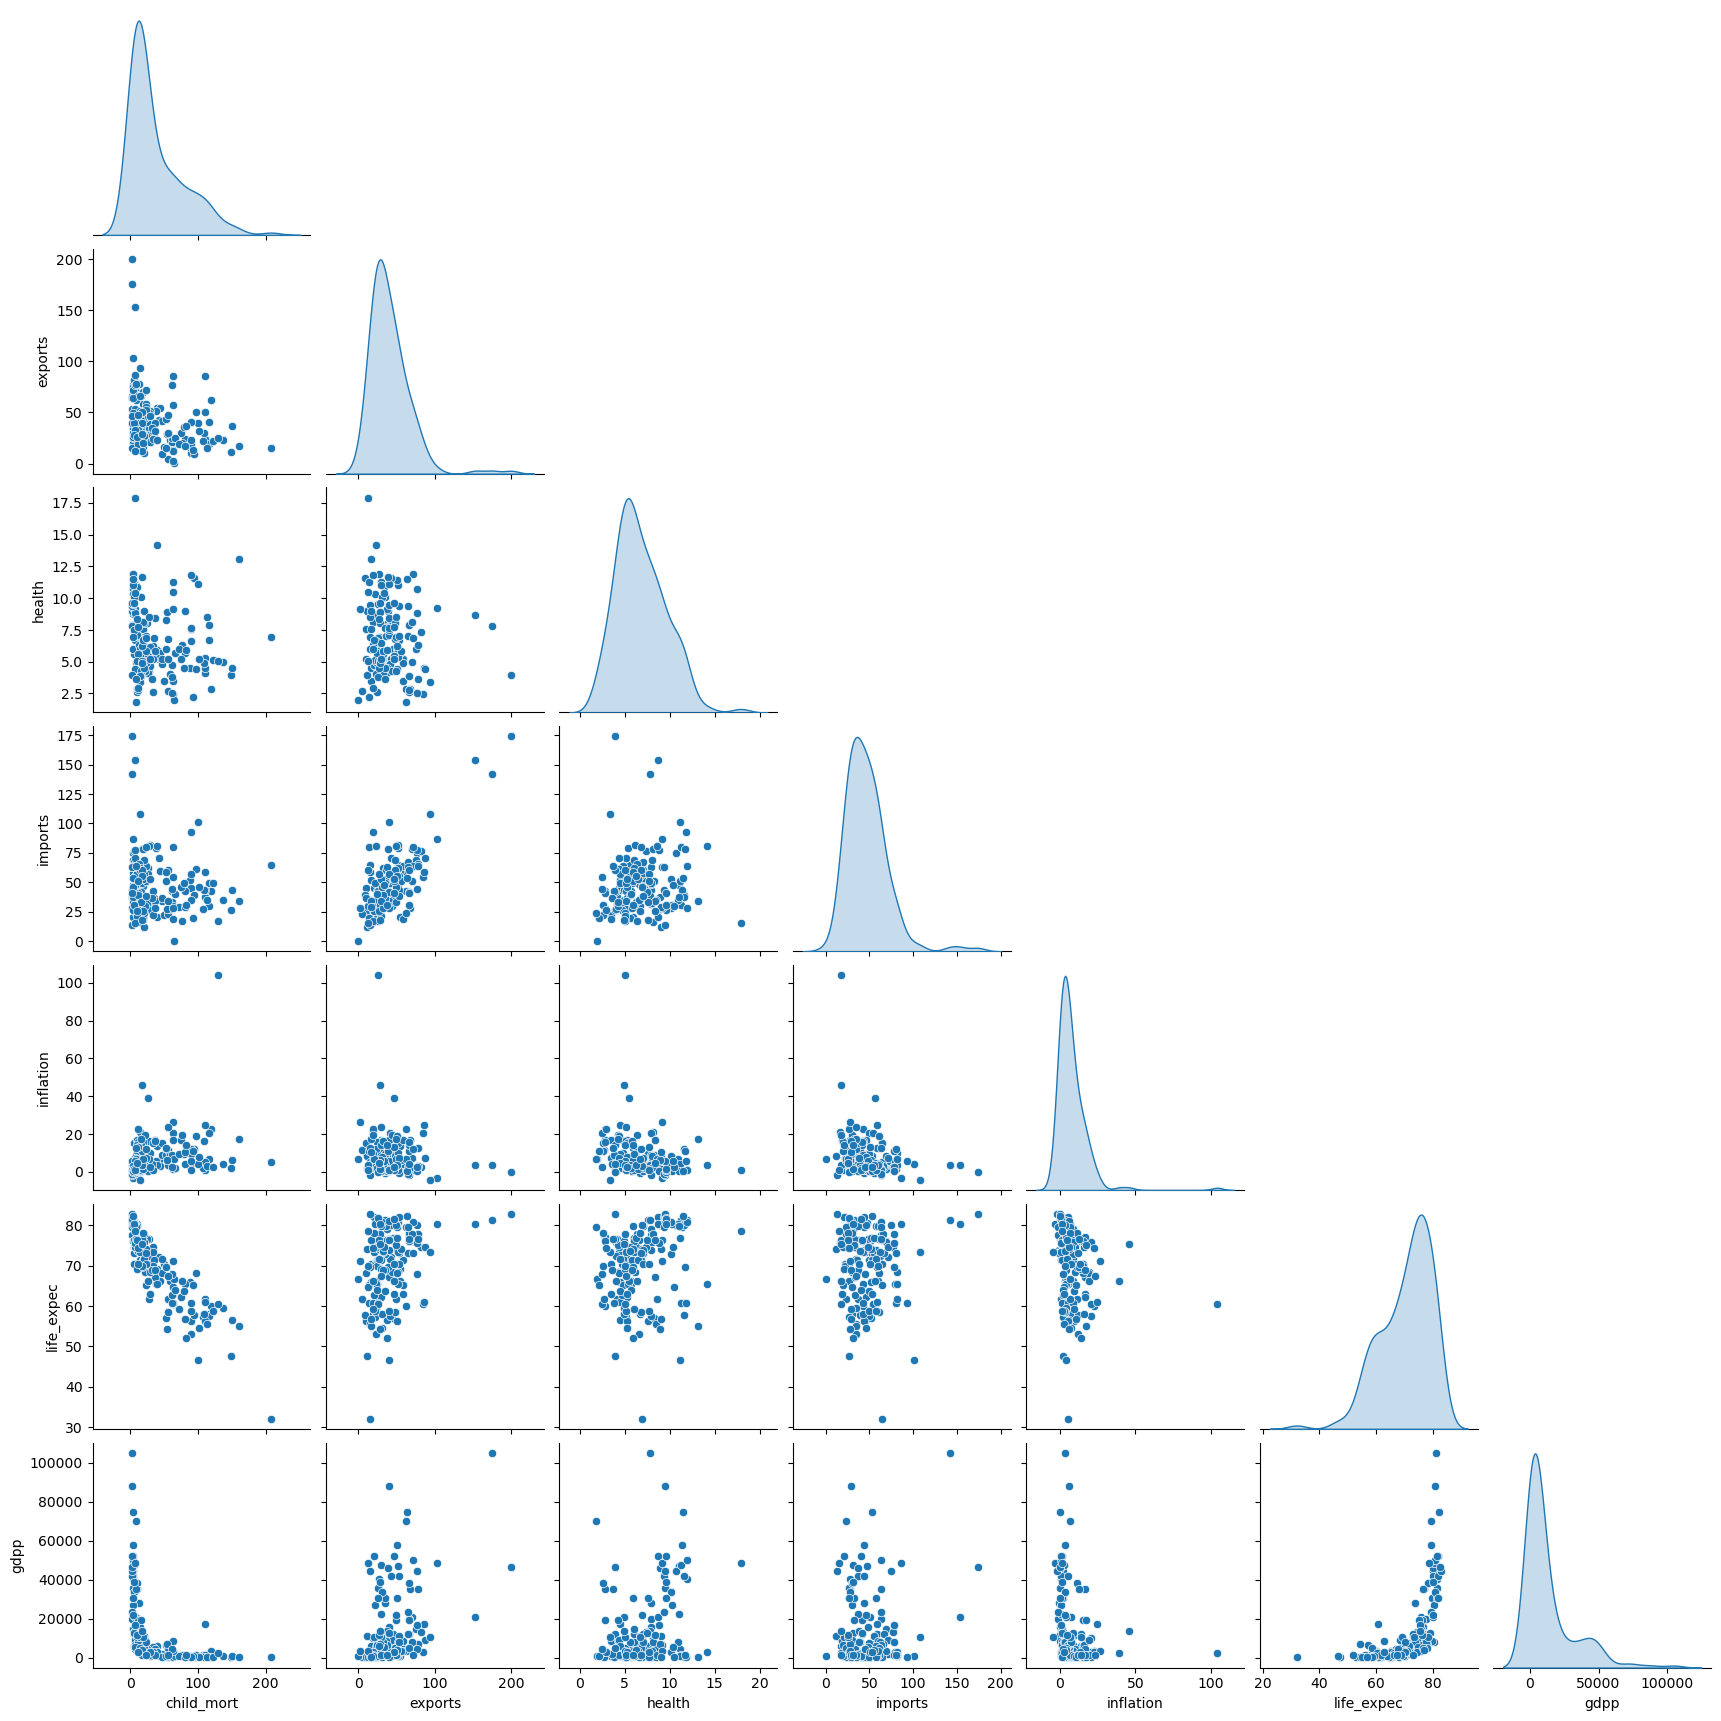

In [8]:
# Now see the relations:

sn.pairplot(x, corner=True,diag_kind='kde')
plt.show()

In [9]:
# use PCA for dimentional reduction:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=23)

x_pca = pca.fit_transform(x)
print(f'{pca.explained_variance_ratio_}\n'
     f'{pca.get_feature_names_out()}')

[9.99992236e-01 4.04272889e-06]
['pca0' 'pca1']


In [10]:
x_df_pca = pd.DataFrame(data=x_pca, columns=pca.get_feature_names_out())

x_df_pca.head(2)

,pca0,pca1
0,-12411.224786,43.703745
1,-8874.131210,-27.526121


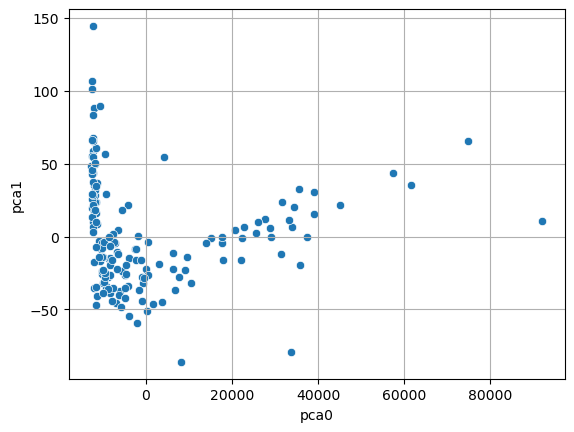

In [11]:
# draw scatter plot:

sn.scatterplot(data=x_df_pca, x='pca0', y='pca1')
plt.grid()
plt.show()

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

## 4 cluster models

 - (2) K-Means models, one for all features, and another for PCA features.
 - (2) Hirarical-clustering models, one for all features, and another for PCA features.

<br><br>
**STEPS:**
- Scale the features.
- Create models.
- Find the best for K-Means models.
- Evaluate the models.

In [14]:
# scales features:

scale = MinMaxScaler()

# (1) scale features:
x_std = scale.fit_transform(x)

# (2) scale features, then make feature reduction:
pca1 = PCA(n_components=2, random_state=23)
pca_std = pca1.fit_transform(x_std)

In [15]:
# create K-Means model function and find the best 'n_clusters':

k_values = np.arange(2, 10, 1)


# K-mean function :

def firstModel(x, k_values):
    inertia_distance = []
    for k in k_values:
        model = KMeans(n_clusters=k, random_state=23).fit(x)
        inertia_distance.append(model.inertia_)
    return inertia_distance


> **Inertia In KMeans:** The distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.<br>
It has an opposite relationship between it and the number of clusters.

In [16]:
# use the function:
import warnings
warnings.filterwarnings('ignore')

kMeans_all_features = firstModel(x_std, k_values)
kMeans_pca_features = firstModel(pca_std, k_values)

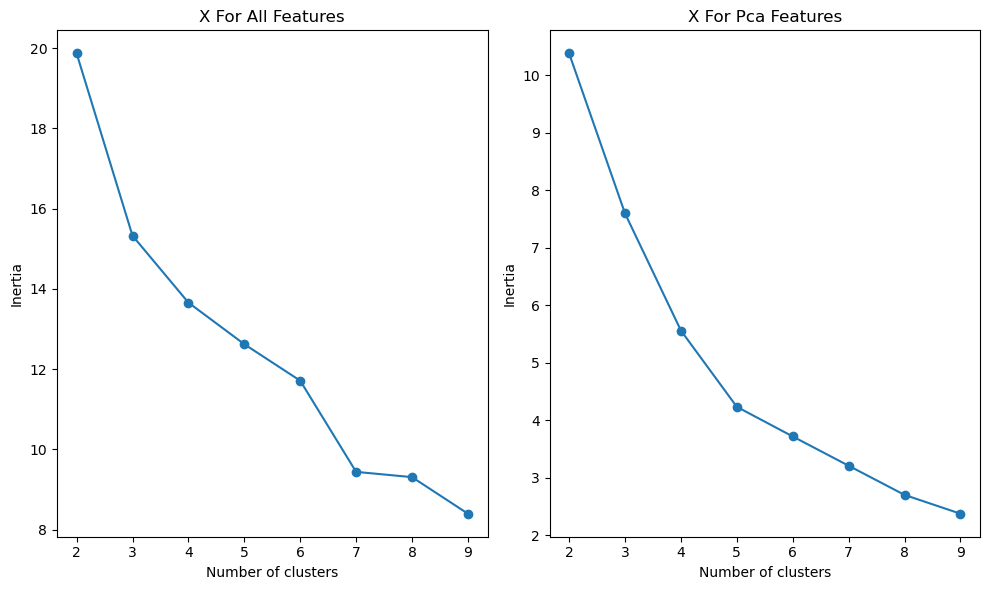

In [17]:
# Draw the graphs:

fig, ax = plt.subplots(1, 2, figsize=(10,6))

# first plot:
ax[0].plot(k_values, np.array(kMeans_all_features), marker='o')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Inertia')
ax[0].set_title('X for all features'.title())

# second plot:
ax[1].plot(k_values, np.array(kMeans_pca_features), marker='o')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Inertia')
ax[1].set_title('X for PCA features'.title())

plt.tight_layout()
plt.show()

**`Elbow Test:`** <br>
Draw a plot graph to see where the elbow created at any n_cluster, which lead to the best K is equal to number that the elbow created in it.<br>

- *First graph:* It not specified well and maybe the elbow created at '3', so need to 'silhouette test'.<br>
- *Second graph:* It almost specified at '4'.

In [18]:
from sklearn.metrics import silhouette_score

def silScore(x, k_values):
    silhouette_list = []
    for k in k_values:
        model = KMeans(n_clusters=k, random_state=23).fit(x)
        silhouette_list.append(silhouette_score(x, model.labels_, metric='euclidean'))

    return silhouette_list

# invoke the function:
s1 = silScore(x_std, k_values)
s2 = silScore(pca_std, k_values)
print(s1)
print(np.max(s1),'\n ----------------------------')
print(s2)
print(np.max(s2),'\n ----------------------------')

[np.float64(0.3281700919294445), np.float64(0.3247697276863593), np.float64(0.22817937248432998), np.float64(0.2202872069027615), np.float64(0.19659147209623107), np.float64(0.21697633090254656), np.float64(0.20258068399563503), np.float64(0.21782229749243448)]
0.3281700919294445 
 ----------------------------
[np.float64(0.416670330509289), np.float64(0.41097146056471034), np.float64(0.4058721997659222), np.float64(0.37767335491674703), np.float64(0.363015963432515), np.float64(0.3399280853711881), np.float64(0.3394445200700396), np.float64(0.35604697259841134)]
0.416670330509289 
 ----------------------------


**`The results of Silhouette Test:`**

- we see that the compressed dataset has better coherence than uncompressed one.
- Even the score converges to one, will get better clustering, even that will chngethat for PCA dataset becuase 2 clusters aren't enough:
- In PCA dataset: the best k is '3'.
- In complete dataset: the best k is '2'

## Draw scatter plot for the best result:

In [19]:
best_Kmeans = KMeans(n_clusters=3, random_state=23).fit(pca_std)


In [20]:
kMean_df = pd.DataFrame(pca_std, columns=pca.get_feature_names_out())
kMean_df['labels'] = best_Kmeans.labels_
kMean_df['gdp'] = df['gdpp']
kMean_df['country'] = countries

kMean_df.head()

,pca0,pca1,labels,gdp,country
0,0.390062,-0.095434,1,553,Afghanistan
1,-0.073627,-0.031353,2,4090,Albania
2,-0.001052,0.033744,2,4460,Algeria
3,0.439499,0.223922,1,3530,Angola
4,-0.156102,0.066476,2,12200,Antigua and Barbuda


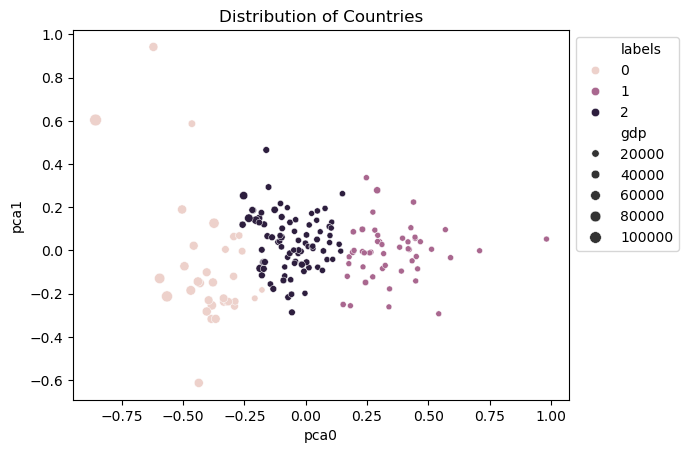

In [21]:
# Draw the scatter plot:

scatter = sn.scatterplot(data=kMean_df, x='pca0', y='pca1', hue='labels',size='gdp')
sn.move_legend(scatter, 'upper left', bbox_to_anchor=(1, 1))
plt.title('Distribution of Countries')
plt.show()

**Insight:**<br>
The model seprate the data to 3 clusters, we see that each cluster has significeint difference which are the have difference in GDP.


**The Goal of Find Hidden Structers:**

See 12 countries, *GCC*, *5 from riched countries*, and *2 from poorest countries*: (Saudi Arabia, Kuwait, Oman, Qatar, United Arab Emirates, Bahrain, China, United States, Ireland, Switzerland, Chad, Mali) where the model clustred them in scatter plot.
Check if *GCC* countries are from reached countries or not based on multiple factors:

- Child Mortality Rate
- Exports (per capita)
- Imports (per capita)
- Health (per capita)
- Income
- Inflation
- Life Expectancy
- Total  Fertility Rate
- GDP ('a measure of a country's economic output')

In [22]:
# find indexes of countries:

wanted_con = ['Saudi Arabia', 'Kuwait', 'Oman', 'Qatar', 'United Arab Emirates', 'Bahrain', 'China', 'United States', 'Ireland', 'Switzerland', 'Chad', 'Mali']
indexes_dic = {}

for i, row in kMean_df.iterrows():
    for c in wanted_con:
        if (row['country'] == c):
            indexes_dic[row['country']] = i

indexes_dic

{'Bahrain': 11,
 'Chad': 32,
 'China': 34,
 'Ireland': 73,
 'Kuwait': 82,
 'Mali': 97,
 'Oman': 115,
 'Qatar': 123,
 'Saudi Arabia': 128,
 'Switzerland': 145,
 'United Arab Emirates': 157,
 'United States': 159}

In [23]:
# check if results were true:

kMean_df.loc[11]

pca0      -0.190127
pca1       0.149419
labels            2
gdp           20700
country     Bahrain
Name: 11, dtype: object

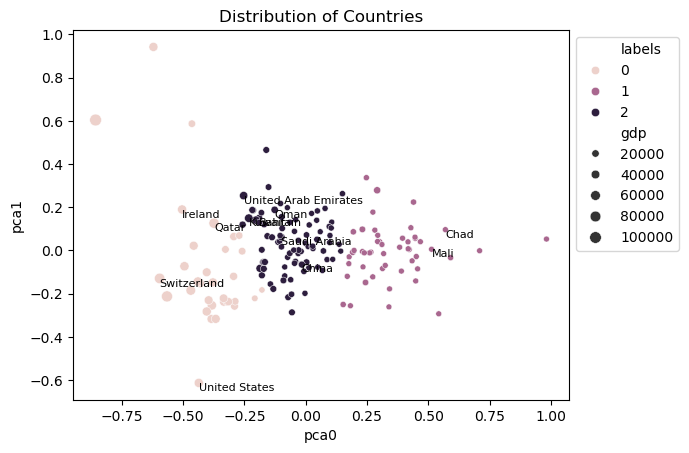

In [24]:
# Draw scatter plot with names:
scatter = sn.scatterplot(data=kMean_df, x='pca0', y='pca1', hue='labels',size='gdp')
sn.move_legend(scatter, 'upper left', bbox_to_anchor=(1, 1))
plt.title('Distribution of Countries')

for key, val in indexes_dic.items():
    plt.text(x=kMean_df.pca0[val], y=kMean_df.pca1[val], s=key, fontsize=8, ha='left', verticalalignment='top', fontfamily='sans-serif')

plt.show()

## Final Results of KMeans Model:

form the final scatter plot we see that the model seperate thte countries to 3 categories which are:
- **poor Countries.**
- **Middle-Income Countries.**
- **Rich Countries.**

Will Evaluate the model based on the list of riched and poorest countries in Visual Capitalist, the link of page: [Countries List](https://www.visualcapitalist.com/ranked-daily-incomes-of-the-richest-and-poorest-in-25-countries/)
<br>

The model predict the countries well that it classify *Chad and Mali* as poor countries, *China, Saudi Arabia, Oman, and Bahrain* as middle-income countries, but if wee see that all of *Saudi Arabia, Oman, and Bahrain* are nearest to rich countries, but not for them at the time when data collected.
And *US, UAE, Irland, Kuwait, Qatar, and Switzerland* classified as riched countries, also notice that the most riched are *Qatar and Switzerland*.

**Notice:** The data aren't new which may collected before 4 years ago, so its expected that the insights were different from now in 2025.

## Use Linkage Model:

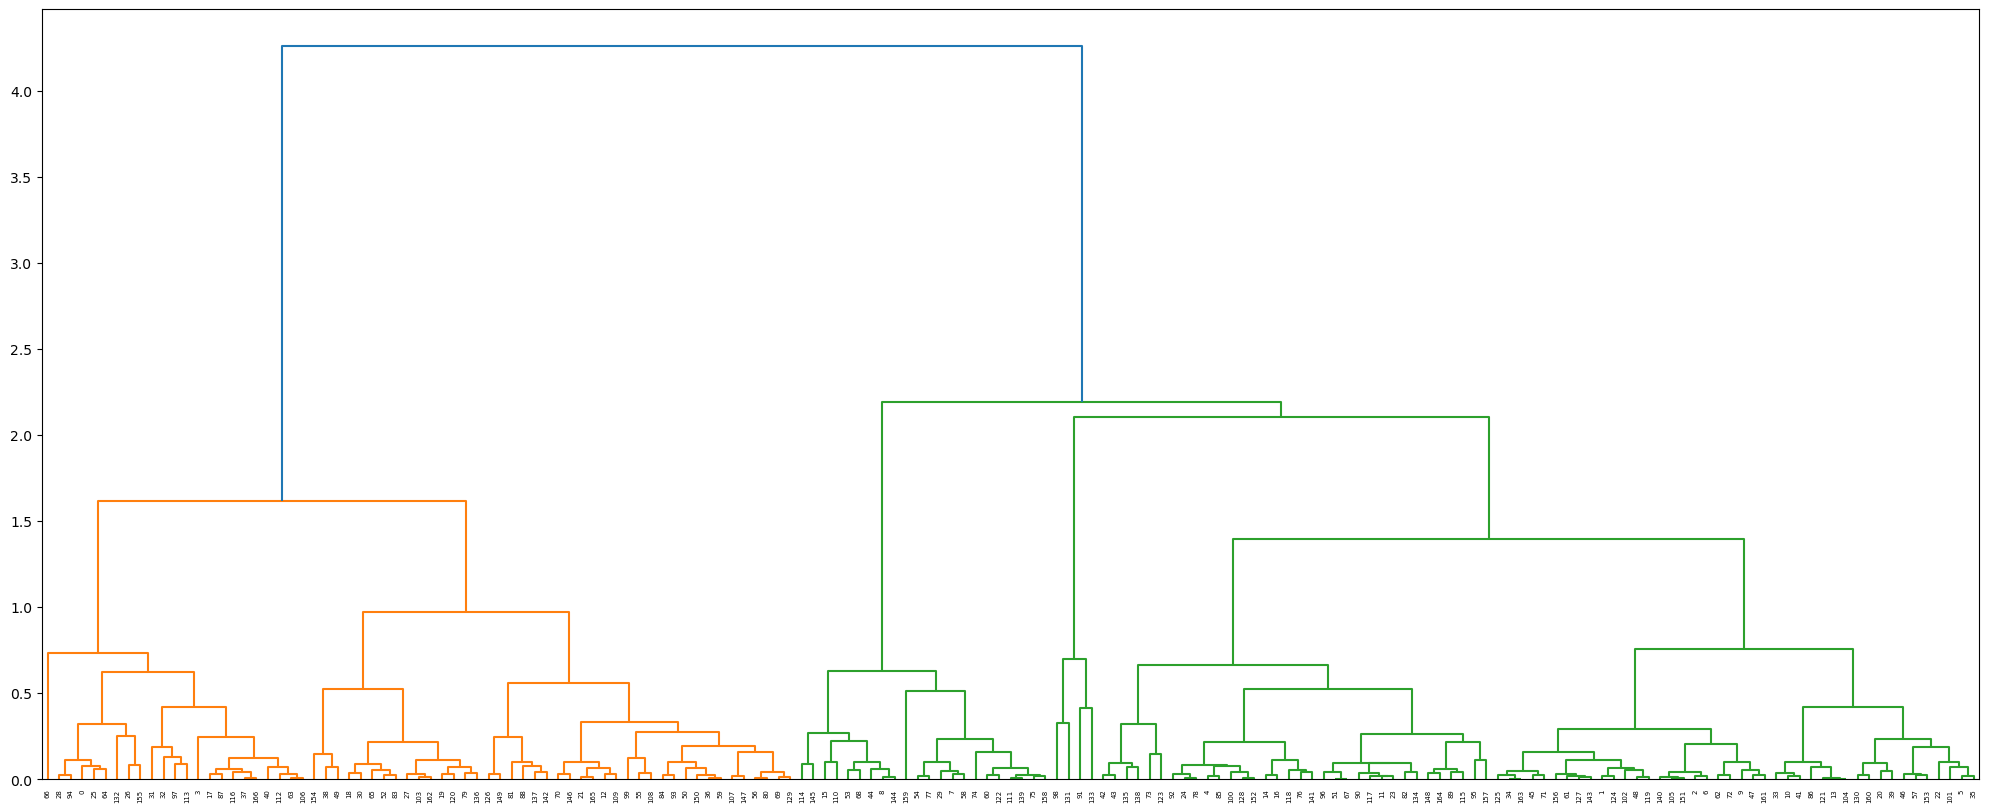

In [25]:
# use 'ward' method:
hirarical_ward = linkage(y=pca_std ,method='ward', metric='euclidean')

# draw dendrogram:
plt.figure(figsize=(25, 10))
dendrogram(hirarical_ward, distance_sort=False,)
plt.show()

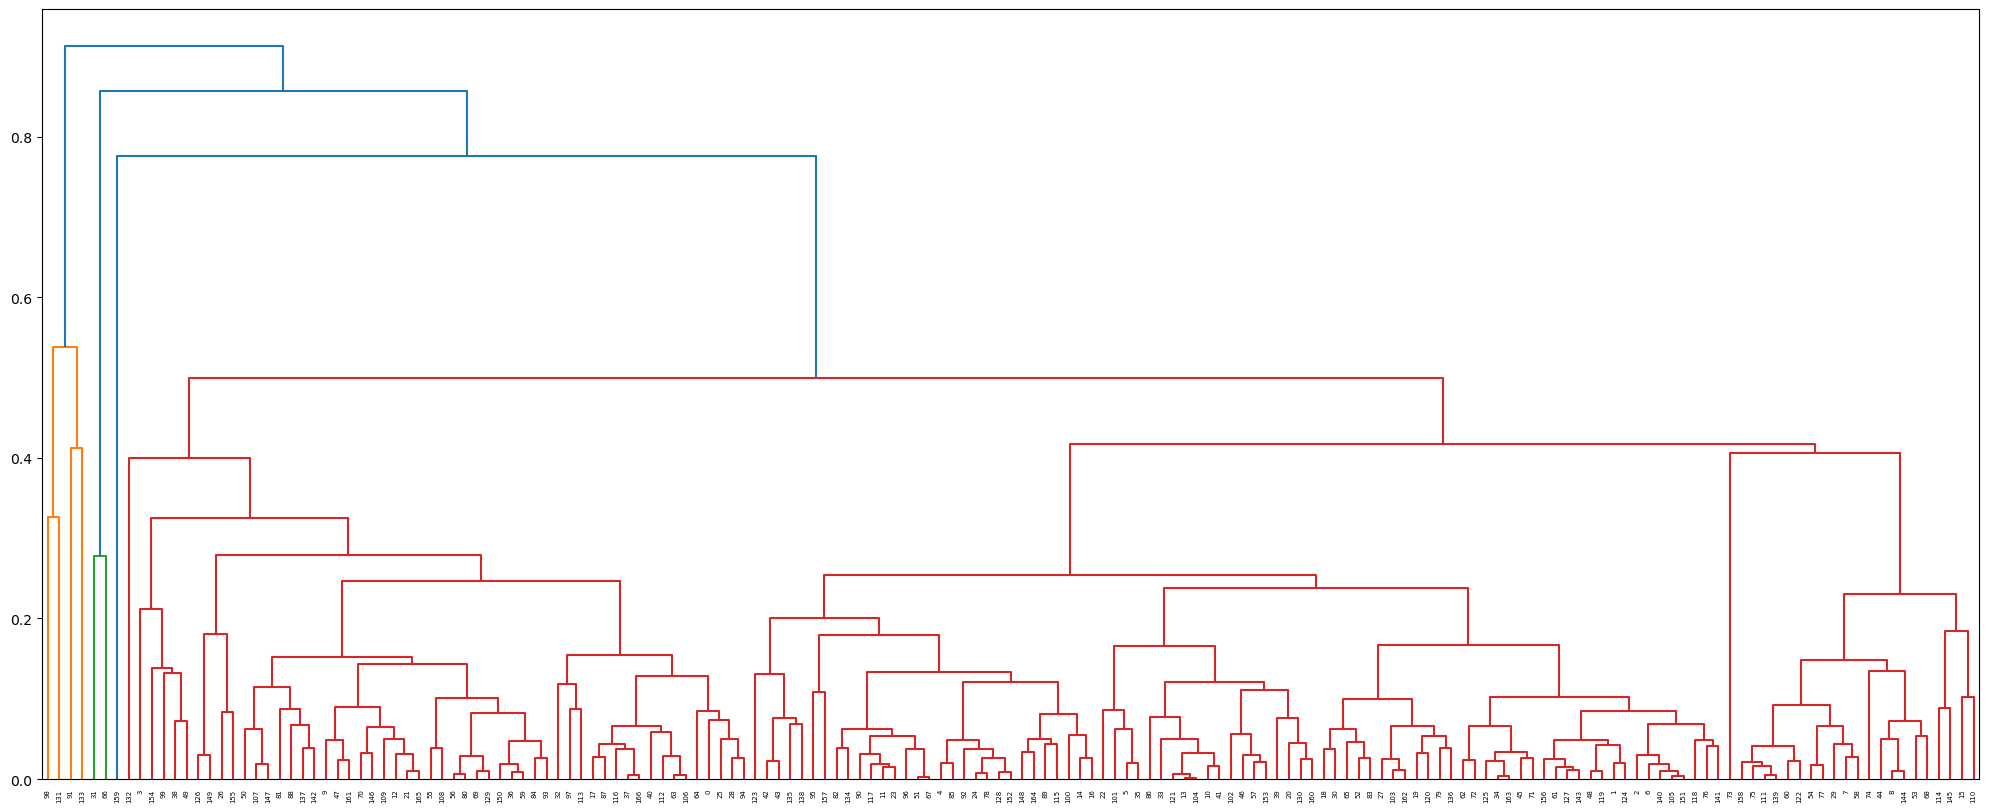

In [26]:
# use 'average' method:
hirarical_average = linkage(y=pca_std ,method='average', metric='euclidean')

# draw dendrogram:
plt.figure(figsize=(25, 10))
dendrogram(hirarical_average, distance_sort=False,)
plt.show()

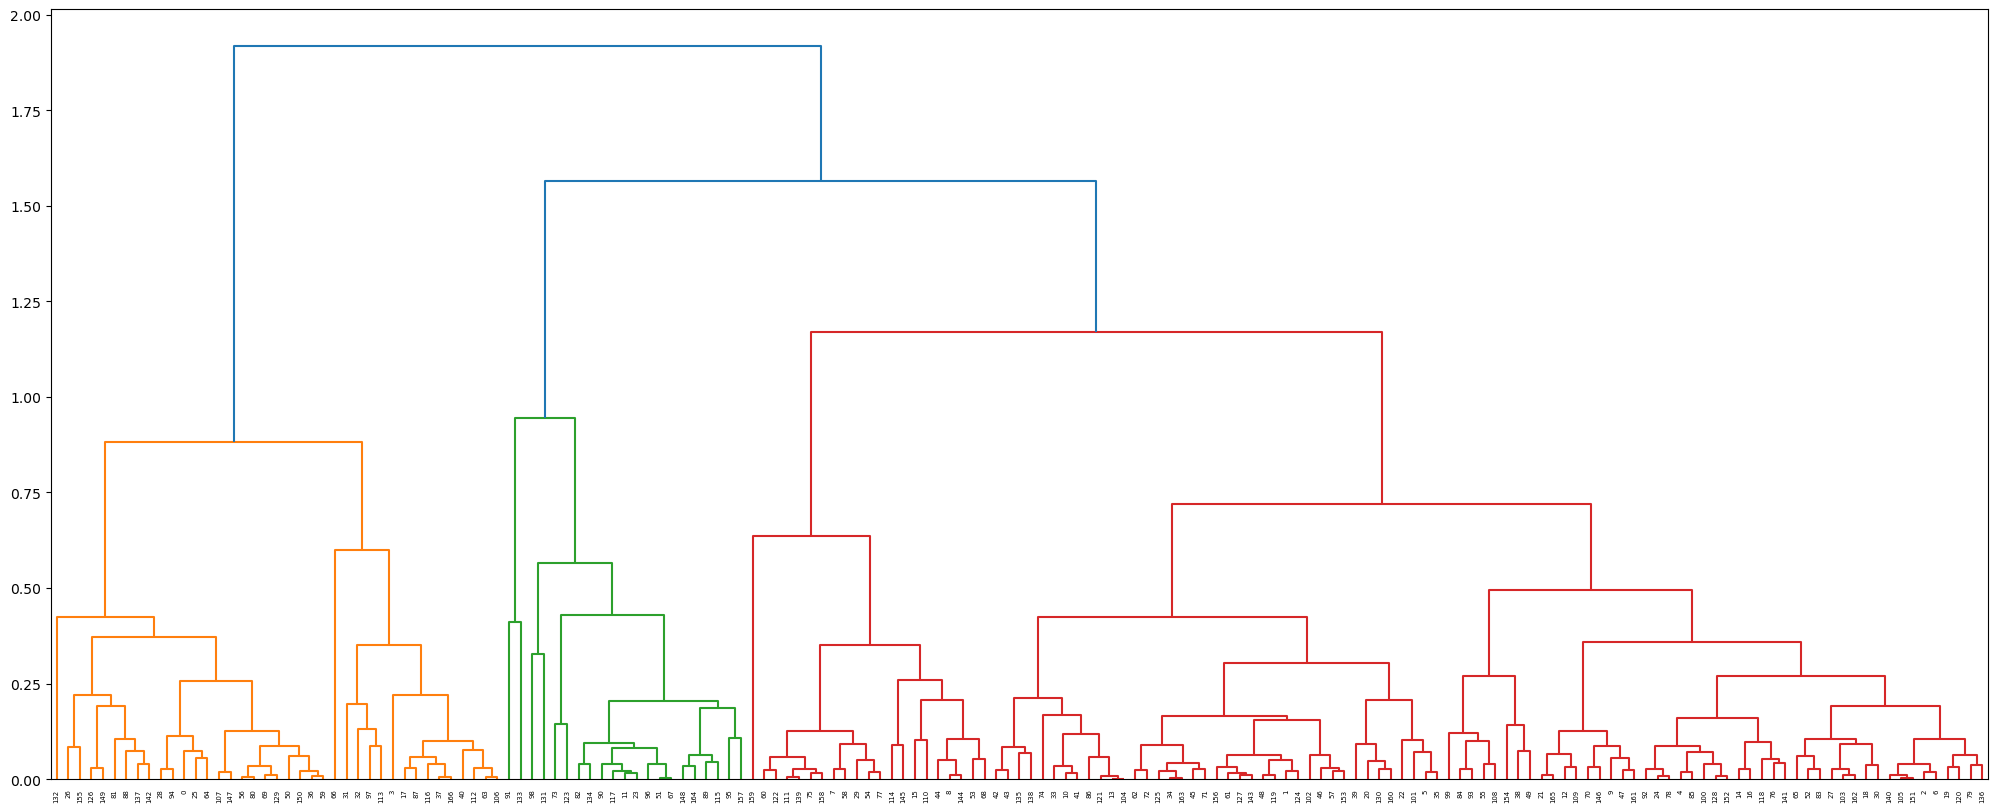

In [27]:
# use 'complete' method:
hirarical_complete = linkage(y=pca_std ,method='complete', metric='euclidean')

# draw dendrogram:
plt.figure(figsize=(25, 10))
dendrogram(hirarical_complete, distance_sort=False,)
plt.show()

**The Difference Between Methods:**

- `ward method` Calculates the distance between two clusters by looking the total of variance increase when the clusters are combined. The goal of it to minmaize the variance.
- `average method` Calculate the average distance between all pairs of points in two clusters.
- `complete method` Calculate the longest distance between two points.

**Draw Horizontal line:**<br>
If draw horizontal line in each graph will find the almost best number of clusters.<br> It has no specific place to draw it, the famouse method is draw the line at large distance in vertical length of column.

- 'ward' : The best number of clusters is '3' (Horizontal line draw at 2 in y-axis)
- 'average' : The best number of clusters is '2' (Horizontal line draw at 0.6 in y-axis)
- 'complete' : The best number of clusters is '3' (Horizontal line draw at 0.9 in y-axis)

**use silhouette_score to masure the quality of hirarical clustering methods:**



In [28]:
from scipy.cluster.hierarchy import fcluster

# import labels from ward method:
ward_cluster = fcluster(hirarical_ward, t=3,criterion='maxclust')

# import labels from average method:
average_cluster = fcluster(hirarical_average, t=2,criterion='maxclust')

# import labels from complete method:
complete_cluster = fcluster(hirarical_complete, t=3,criterion='maxclust')

In [29]:
# silhouette_score:
print(f'---------------------------------------------------------------\nHirarical Model:\n'
    f'For ward method: {silhouette_score(pca_std, ward_cluster)}\n'
    f'For average method: {silhouette_score(pca_std, average_cluster)}\n'
    f'For complete method: {silhouette_score(pca_std, complete_cluster)}\n'
    f'-----------------------------------------------------------------\nKMean Model:\n'
    f'KMeans model for pca features with 3 clusters: {silScore(pca_std, k_values)[1]}')

---------------------------------------------------------------
Hirarical Model:
For ward method: 0.3766465004676047
For average method: 0.5623413419327418
For complete method: 0.3002677131206403
-----------------------------------------------------------------
KMean Model:
KMeans model for pca features with 3 clusters: 0.41097146056471034


**Results:**
- From results of silhouette test we see that the best one was the average method with 2 clusters, then the KMeans model with 3 clusters.
- We discarded the '2' clusters besause we motivaited to see more complex hidden structers not simple one.

## Final Analysis for GCC Countries:

After discover the best model for clustering the countries, find the patterns for each one, now will use data analysis for discover more information, and why they categorized as that.

In [30]:
# see the clolumns:
df.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [40]:
gcc_countries = wanted_con[0:6]
gcc_dic = {}

for key, val in indexes_dic.items():
    for gcc in gcc_countries:
        if key == gcc:
            gcc_dic[key] = val

gcc_dic

{'Bahrain': 11,
 'Kuwait': 82,
 'Oman': 115,
 'Qatar': 123,
 'Saudi Arabia': 128,
 'United Arab Emirates': 157}

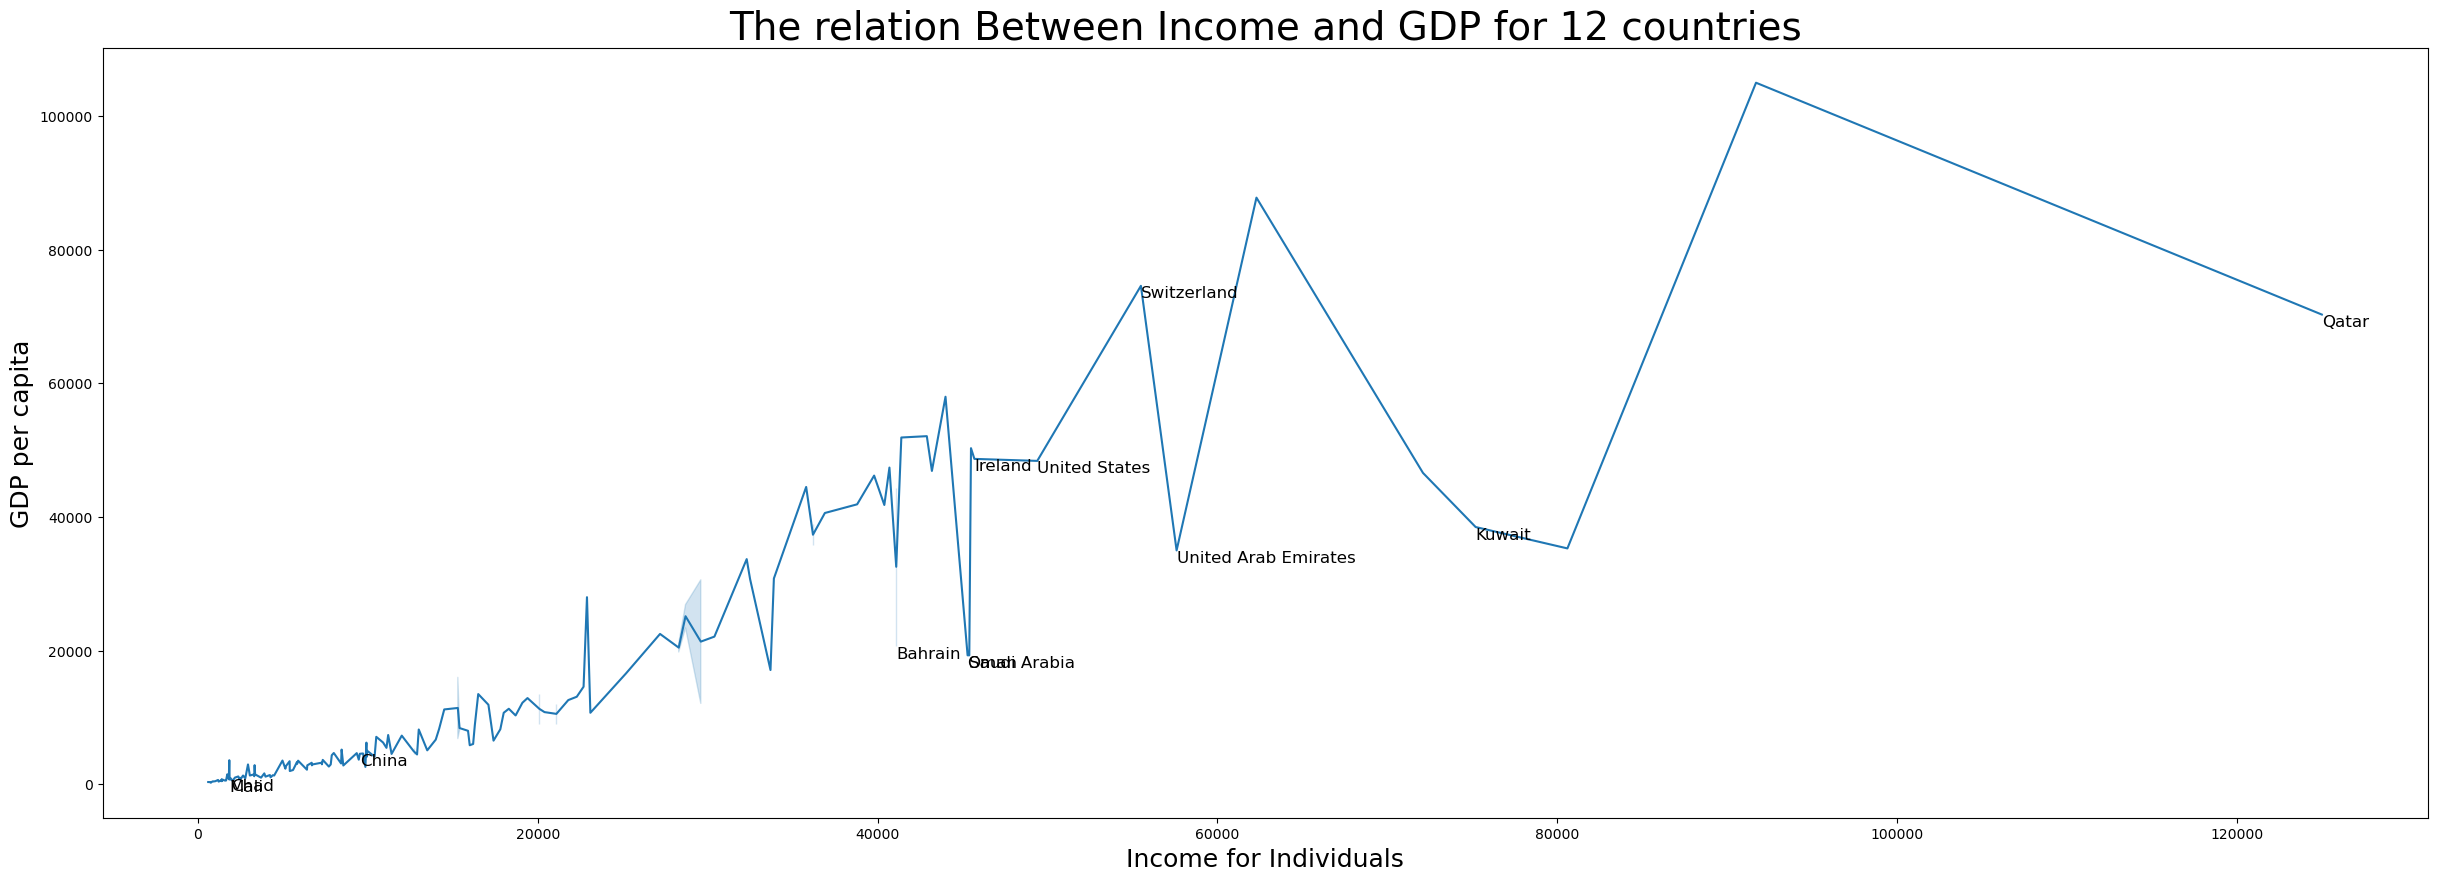

In [50]:
# line plot for gdp and income:

plt.figure(figsize=(30,10))
sn.lineplot(data=df, x='income',y='gdpp')

for key, val in indexes_dic.items():
    plt.text(df['income'].loc[val], df['gdpp'].loc[val], s=key, fontsize=12, ha='left', verticalalignment='top', fontfamily='sans-serif')

plt.title('The relation Between Income and GDP for 12 countries', fontsize= 28)
plt.xlabel('Income for Individuals', fontsize=18)
plt.ylabel('GDP per capita', fontsize=18)
plt.show()

**Insights of Relation Between GDP and Income:**

- From thte graph can see the reason of why *Qatar* and *Switzerland* are one from riched countries, *Qatar* has almost 125,000 as income for individuals, and 68,000 as GDP per capita, with these high income and GDP was high reasons to place *Qatar* from the most riched countries. Also for  *Kuwait* with 78,000 as income, and 40,000 as GDP, *UAE* with 58,000 income and 39,000 GDP that placed them as from riched countries but not as *Qatar*.

- If see *Saudi Arabia* will find its income almost 45,000 and 19,000 GDP which lead to become near from the basic points to become rich country, but not at the time when data collected.<br>
The reasons of why *Saudi Arabia* is not from riched countries can specify them to:
1. The large area which equal to 2,150,000 km2, Saudi Arabia is the largest country in *GCC* countries.
2. It's depends on oil and petrochemicals, it has no large prodects to export.
3. It didn't have ready tourism facilities at that time.

Also if see to other countries such as *Bahrain* and *Oman* will find the same problem at them, which is they depend on oil and its derivatives.


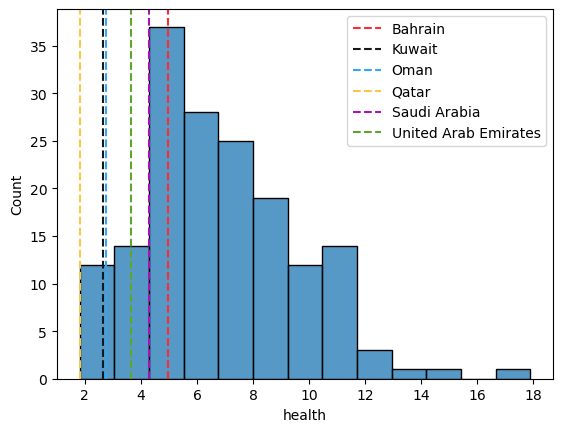

In [86]:
# draw histogram for health:

c = ['#FB2C36','#18181B','#34A6F4','#FDC745', '#A813B7', '#5EA529', '#FB64B6']
count = 0

sn.histplot(data=df, x='health')

for key, val in gcc_dic.items():
    plt.axvline(x=df.health.loc[val], color=c[count], linestyle='--', label=key)
    count += 1

plt.legend()
plt.show()

**Insights of Health:**<br>
The health at this dataset means: The overall well-being of country's citizens.<br>
becuase the data is old, can tell the arrange of countries isn't true based on (World Bank 2024, Health Index by Country).

- the arrange in graph (from lowest): *Qatar , Kuwait, Oman, UAE, Saudi Arabi, Bahrain*
- the arrange in World Bank (from lowest): *Oman, Bahrain, Saudi Arabia, Kuwait, Qatar*

Reasons of why the data in this dataset didn't match the real data:

- the dataset is old.
- *GCC* countries motivited to grow up fast in short time, can see that by The World Cup 2023 'Fifa' in *Qatar*, and projects related to 2030 vision in *Saudi Arabia*. Also they grow up togather by shared projects.

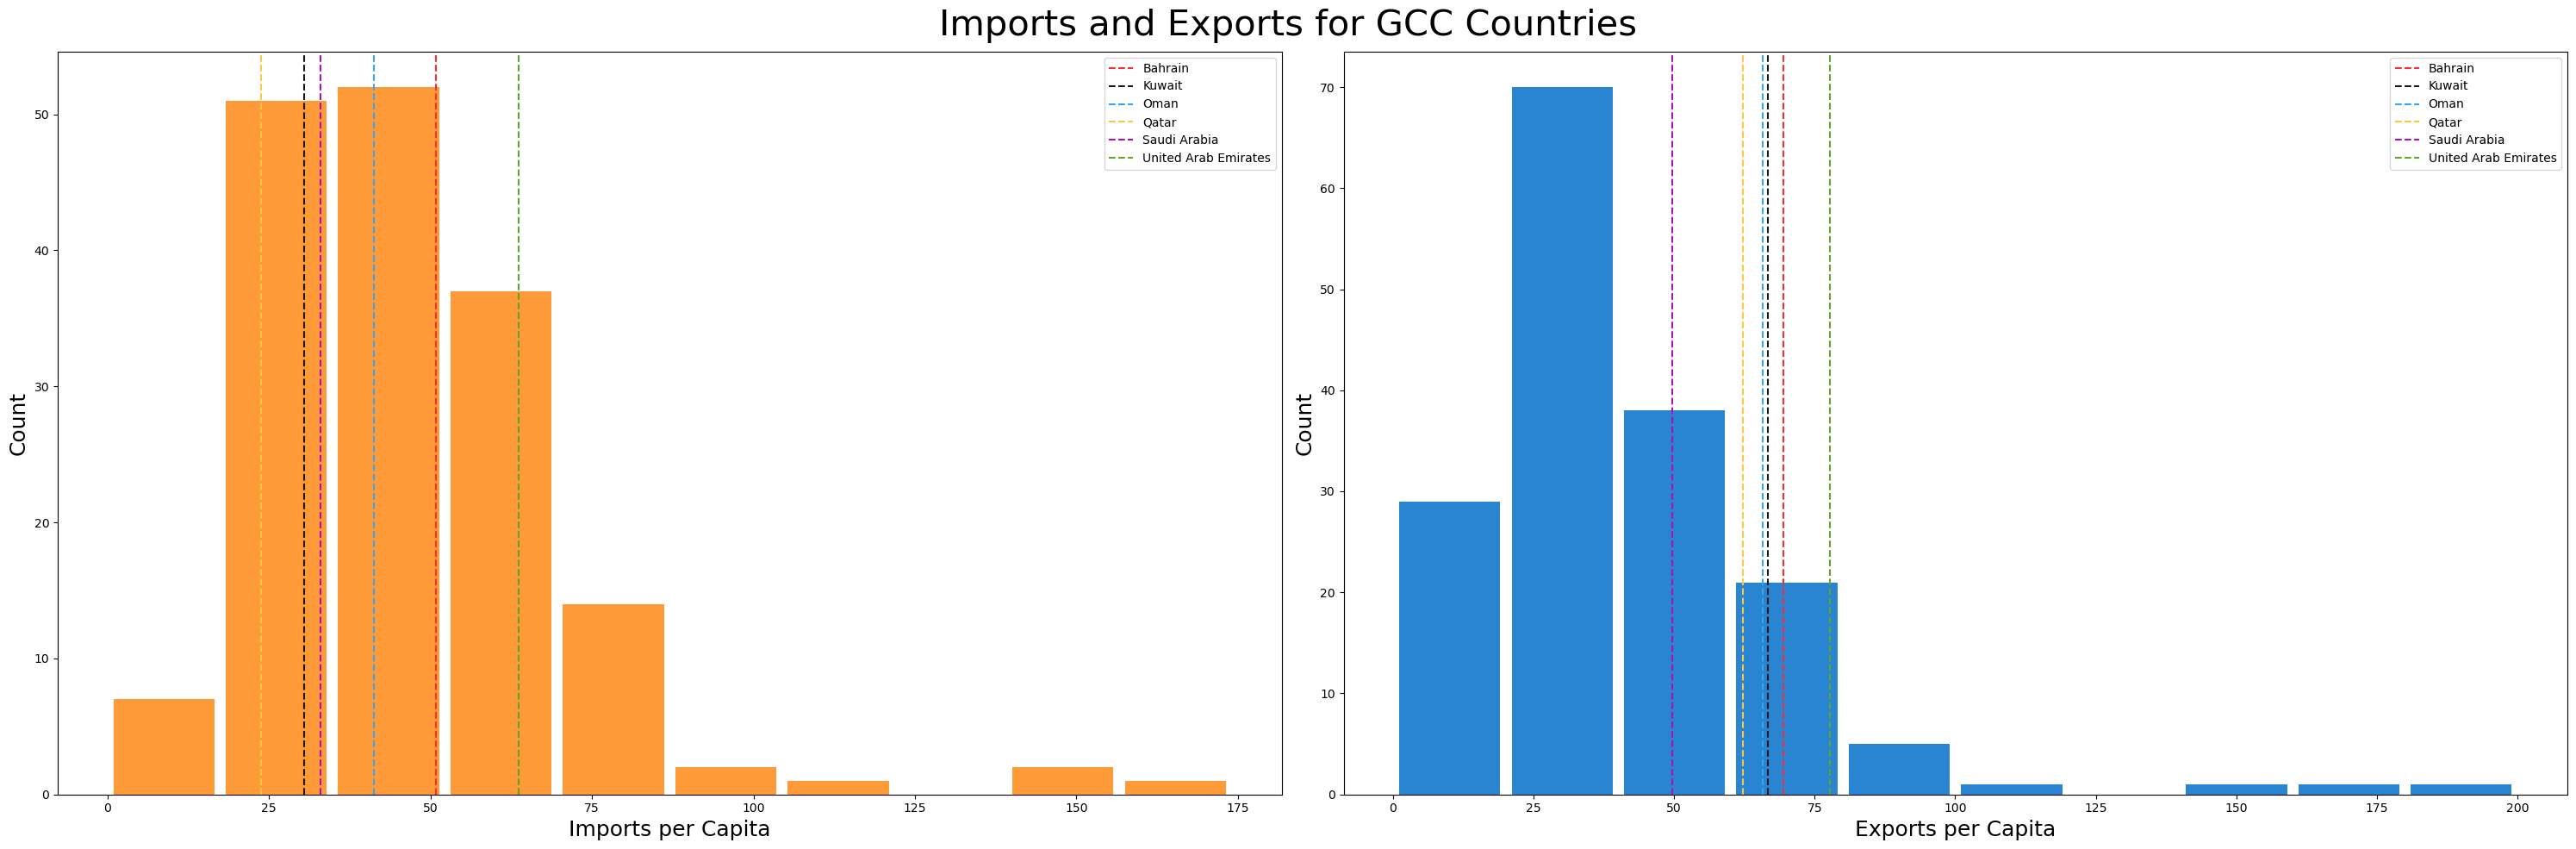

In [87]:
# draw histogram for imports and exports:
import_count = 0
export_count = 0


fig, ax = plt.subplots(1,2, figsize=(30,10))

# for imports:
ax[0].hist(x=df.imports, rwidth= 0.9, color='#FE9A37')
for key, val in gcc_dic.items():
    ax[0].axvline(x=df.imports.loc[val], color=c[import_count], linestyle='--', label=key)
    import_count += 1
    
ax[0].set_xlabel('Imports per Capita', fontsize=18)
ax[0].set_ylabel('Count', fontsize=18)
ax[0].legend(fontsize=10)

# for exports:
ax[1].hist(x=df.exports, rwidth= 0.9, color='#2984D1')
for key, val in gcc_dic.items():
    ax[1].axvline(x=df.exports.loc[val], color=c[export_count], linestyle='--', label=key)
    export_count += 1
    
ax[1].set_xlabel('Exports per Capita', fontsize=18)
ax[1].set_ylabel('Count', fontsize=18)
ax[1].legend(fontsize=10)   


plt.suptitle('Imports and Exports for GCC Countries', fontsize=30)
plt.tight_layout()
plt.show()

**Insights of Imports and Exports:**

- From Two graphs, the *GCC* countries enhanced in exports, which in the past they considred of countries that imports more than exports. But in graph have different result.
- For Imports: The most *GCC* country that import is *UAE*, and the least one is *Qatar*. the reason of why *UAE* is from the most touristic country in *GCC*.
- For Exports: The *UAE* is the highest exporter among GCC countries due to its diversified economy and its role as a regional trade hub. However, its exports are heavily reliant on crude oil, which can lead to fluctuations in export value due to global oil prices and OPEC production cuts. While Saudi Arabia is diversifying its economy, its dependence on oil remains a significant factor.

`Remamber` High **Imports** may reflect dependency on foreign production, which can be unhealthy for the economy. In contrast, high **Exports** often indicate stronger economic performance